In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [2]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

## MNIST dataset

In [3]:
import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [4]:
mnist = datasets.FashionMNIST()
# mnist.download_mnist()
# mnist.save_mnist()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [5]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [6]:
input_size = 784
output_size = 10

In [7]:
class MNIST_Dataset(data.Dataset):
    
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
#         print(idx)
        img, lbl = self.data[idx], self.label[idx]
        return img, lbl

In [8]:
train_dataset = MNIST_Dataset(train_data, train_label)
test_dataset = MNIST_Dataset(test_data, test_label)

In [9]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset,
                                    num_workers=4, 
                                    batch_size=batch_size, 
                                    shuffle=True)

test_loader = data.DataLoader(dataset=test_dataset,
                                    num_workers=1, 
                                    batch_size=batch_size, 
                                    shuffle=False)

In [11]:
class DistanceTransform(nn.Module):
    
    def __init__(self, input_dim, num_centers, p=2):
        super().__init__()
        self.input_dim = input_dim
        self.num_centers = num_centers
        self.p = p
        
        self.centers = torch.randn(num_centers, input_dim)/3.
#         self.centers = torch.rand(num_centers, input_dim)
        self.centers = nn.Parameter(self.centers)
    
    def forward(self, x):
        dists = torch.cdist(x, self.centers, p=self.p)
        
        ### normalize similar to UMAP
#         dists = dists-dists.min(dim=1, keepdim=True)[0]
#         dists = dists-dists.mean(dim=1, keepdim=True)
#         dists = dists/dists.std(dim=1, keepdim=True)

        return dists
    
    def set_centroid_to_data_randomly(self, data_loader):
        indices = np.random.permutation(len(data_loader.dataset.data))[:self.centers.shape[0]]
        self.centers.data = data_loader.dataset.data[indices].to(self.centers.device)
        pass
    
    def set_centroid_to_data_maxdist(self, data_loader):
        ## sample N points
        N = self.centers.shape[0]
        new_center = torch.empty_like(self.centers)
        min_dists = torch.empty(N)
        count = 0
        for i, (xx, _) in enumerate(tqdm(data_loader)):
            if count < N:
                if N-count < batch_size:
                    #### final fillup
                    new_center[count:count+N-count] = xx[:N-count]
                    xx = xx[N-count:]
                    dists = torch.cdist(new_center, new_center)+torch.eye(N)*1e5
                    min_dists = dists.min(dim=0)[0]
                    count = N

                else:#### fill the center
                    new_center[count:count+len(xx)] = xx
                    count += len(xx)
                    continue

            ammd = min_dists.argmin()
            for i, x in enumerate(xx):
                dists = torch.norm(new_center-x, dim=1)
                md = dists.min()
                if md > min_dists[ammd]:
                    min_dists[ammd] = md
                    new_center[ammd] = x
                    ammd = min_dists.argmin()
        self.centers.data = new_center.to(self.centers.device)
        pass
        
    
    def set_centroid_to_data(self, data_loader):
        new_center = self.centers.data.clone()
        min_dists = torch.ones(self.centers.shape[0])*1e9

        for xx, _ in data_loader:

            dists = torch.cdist(xx, self.centers.data)
            ### min dist of each center to the data points
            min_d, arg_md = dists.min(dim=0)

            ### dont allow same point to be assigned as closest to multiple centroid
            occupied = []
            for i in np.random.permutation(len(arg_md)):
        #     for i, ind in enumerate(arg_md):
                ind = arg_md[i]
                if ind in occupied:
                    min_d[i] = min_dists[i]
                    arg_md[i] = -1
                else:
                    occupied.append(ind)

            ### the index of centroids that have new min_dist
            idx = torch.nonzero(min_d<min_dists).reshape(-1)

            ### assign new_center to the nearest data point
            new_center[idx] = xx[arg_md[idx]]
            min_dists[idx] = min_d[idx]
            
        self.centers.data = new_center.to(self.centers.device)
        pass

## Umap pytorch GD

In [12]:
from scipy.optimize import curve_fit

In [13]:
class EMA(object):

    def __init__(self, momentum=0.1, mu=None):
        self.mu = mu
        self.momentum = momentum

    def __call__(self, x):
        if self.mu is None:
            self.mu = x
        self.mu = self.momentum*self.mu + (1.0 - self.momentum)*x
        return self.mu

In [40]:
## https://github.com/lmcinnes/umap/blob/master/umap/umap_.py

class UMapper(nn.Module):
    
    def __init__(self, input_dim, output_dim, num_centers, num_neighbour,
                 min_dist=0.1, spread=1.0, negative_sample_rate=5):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.min_dist = min_dist
        self.spread = spread
        self.num_neighbour = num_neighbour
        self.num_centers = num_centers
        self.negative_sample_rate = negative_sample_rate
        self.a, self.b = self.find_ab_params(spread, min_dist)
        
        self.x_centers = nn.Parameter(torch.randn(num_centers, input_dim)/3.)
        self.y_centers = nn.Parameter(torch.randn(num_centers, output_dim)/3.)
        self.criterion = nn.BCELoss()
        
        self.sigma = EMA()
        pass
    
    def compute_loss(self):
        x = self.x_centers
        assert x.shape[0] > self.num_neighbour
        
        neg_num = min(self.negative_sample_rate, x.shape[0]-self.num_neighbour)*self.num_neighbour
#         neg_num = self.negative_sample_rate*self.num_neighbour

        ### positive sampling only
        dists = torch.cdist(x, x)+torch.eye(x.shape[0]).to(x.device)*1e5
        dists, indices = torch.topk(dists, k=self.num_neighbour, dim=1, largest=False, sorted=False)

        dists = (dists-dists.min(dim=1, keepdim=True)[0])
#                     /torch.sqrt(dists.var(dim=1, keepdim=True)+1e-5)
        sigma = self.sigma(self.get_sigma(dists.data, epoch=10))
        dists = dists/sigma
        dists = torch.exp(-dists)

        probX = torch.zeros(dists.shape[0], dists.shape[0]).to(x.device)
        probX.scatter_(dim=1, index=indices, src=dists)
        probX = probX+probX.t()-probX*probX.t()
        ## randomly sample from the probX, some points in same class are left alone
#         rand_indices = torch.randint(low=0, high=x.shape[0], size=(x.shape[0], self.num_neighbour//4)).to(indices.device)
#         indices = torch.cat([indices, rand_indices], dim=1)
        probX = torch.gather(probX, dim=1, index=indices)
        
        
        ### NOW on Y
        dists = torch.cdist(self.y_centers, self.y_centers)
        
        probY = torch.gather(dists, dim=1, index=indices)
        probY = 1/(1+self.a*(probY**(2*self.b)))
        loss_positive = self._bceloss_(probX, probY)
        
        probX = torch.zeros(x.shape[0], neg_num, device=x.device)
        negative_indices = torch.randint(low=0, high=x.shape[0], size=(x.shape[0], neg_num)).to(indices.device)
        probY = torch.gather(dists, dim=1, index=negative_indices)
        probY = 1/(1+self.a*(probY**(2*self.b)))
        
        loss_negative = self._bceloss_(probX, probY)
        ### if mean is used
        loss = loss_positive+loss_negative*self.negative_sample_rate
        ### if sum is used
#         loss = (loss_positive+loss_negative)*1/(x.shape[0]*self.num_neighbour)
    
        return loss
    
    def get_sigma(self, dists, epoch=300):
        sigma = nn.Parameter(torch.std(dists.data, dim=1, keepdim=True)*0.2)
        optim = torch.optim.Adam([sigma], lr=0.03)
        target = torch.log2(torch.ones_like(sigma)*dists.shape[1]).to(dists.device)
        for i in range(epoch):
            delta = torch.sum(torch.exp(-dists/sigma), dim=1, keepdim=True)
            delta = delta-target

            optim.zero_grad()
            error = (delta**2).sum()
            error.backward()
            optim.step()

        return sigma.data
    
    def _bceloss_(self, pX, pY):
        logy = torch.clamp(torch.log(pY), min=-100)
        log1_y = torch.clamp(torch.log(1-pY), min=-100)
#         logy = torch.log(pY)
#         log1_y = torch.log(1-pY)
        return -torch.mean(pX*logy+(1-pX)*log1_y)
#         return -torch.sum(pX*logy+(1-pX)*log1_y)

    def find_ab_params(self, spread, min_dist):

        def curve(x, a, b):
            return 1.0 / (1.0 + a * x ** (2 * b))

        xv = np.linspace(0, spread * 3, 300)
        yv = np.zeros(xv.shape)
        yv[xv < min_dist] = 1.0
        yv[xv >= min_dist] = np.exp(-(xv[xv >= min_dist] - min_dist) / spread)
        params, covar = curve_fit(curve, xv, yv)
        return params[0], params[1]
        

In [58]:
ump = UMapper(784, 2, num_centers=784, num_neighbour=100, negative_sample_rate=5).to(device)

indices = np.random.permutation(len(train_loader.dataset.data))[:784]
xx, yy = train_loader.dataset[indices]

ump.x_centers.data = xx.to(device)

In [59]:
ump.a, ump.b

(1.576943460405378, 0.8950608781227859)

In [60]:
ump.compute_loss()

tensor(8.4147, device='cuda:0', grad_fn=<AddBackward0>)

In [61]:
optimizer = torch.optim.Adam(ump.parameters(), lr=0.5)

In [62]:
optimizer.param_groups

[{'params': [Parameter containing:
   tensor([[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', requires_grad=True),
   Parameter containing:
   tensor([[ 0.0253, -0.0149],
           [ 0.1893,  0.0151],
           [-0.4805,  0.1964],
           ...,
           [ 0.3094, -0.3579],
           [ 0.2004, -0.2882],
           [ 0.2021,  0.3672]], device='cuda:0', requires_grad=True)],
  'lr': 0.5,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False}]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 0,  Loss:8.488777160644531


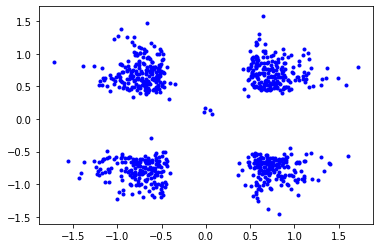

  5%|▍         | 499/10000 [00:07<02:26, 64.95it/s]

Epoch: 500,  Loss:0.6779347658157349


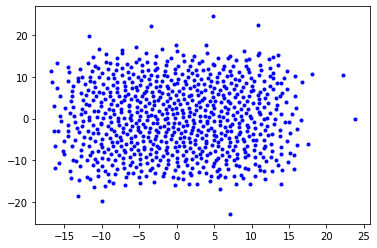

 10%|▉         | 996/10000 [00:15<02:20, 64.26it/s]

Epoch: 1000,  Loss:0.6873398423194885


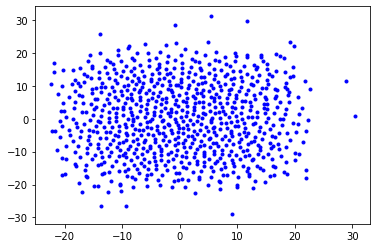

 15%|█▌        | 1500/10000 [00:23<02:10, 65.30it/s]

Epoch: 1500,  Loss:0.6542435884475708


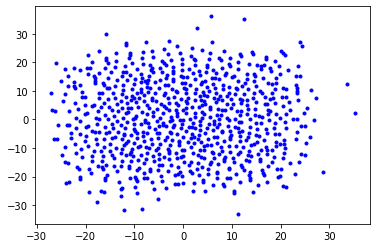

 20%|█▉        | 1997/10000 [00:31<02:05, 63.74it/s]

Epoch: 2000,  Loss:0.6674053072929382


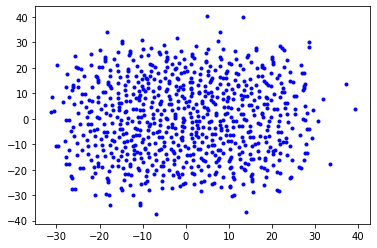

 25%|██▍       | 2494/10000 [00:38<01:55, 64.87it/s]

Epoch: 2500,  Loss:0.6728525161743164


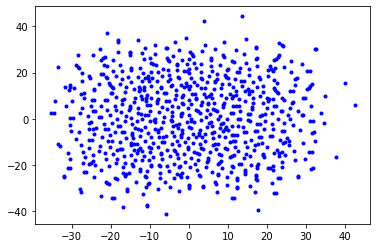

 30%|██▉       | 2998/10000 [00:46<01:48, 64.73it/s]

Epoch: 3000,  Loss:0.7165709137916565


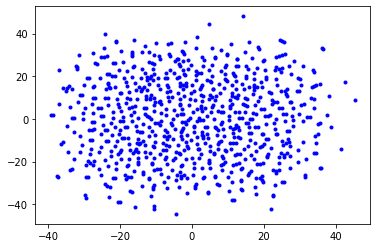

 35%|███▍      | 3458/10000 [00:53<01:41, 64.14it/s]


KeyboardInterrupt: 

In [63]:
#### Train with Optimizer

train_error = []
for epoch in tqdm(list(range(10000))):
    loss = ump.compute_loss()
    optimizer.zero_grad()
    loss.backward()
    
#     print(ump.y_centers.grad)
#     print(torch.count_nonzero(torch.isnan(ump.y_centers.grad)))
#     print(torch.count_nonzero(torch.isinf(ump.y_centers.grad)))
    ump.y_centers.grad[torch.isnan(ump.y_centers.grad)] = 0
    ump.x_centers.grad[torch.isnan(ump.x_centers.grad)] = 0
    
    
    optimizer.step()
#     stdm = ump.y_centers.data.std()
#     ump.y_centers.data = ump.y_centers.data + \
#                 (torch.rand_like(ump.y_centers.data)-0.5)*0.01*float(stdm)

    train_error.append(float(loss))
    
    if epoch%500 == 0:
#         print(ump.y_centers.data.std())
        print(f'Epoch: {epoch},  Loss:{float(loss)}')
        plt.scatter(*ump.y_centers.cpu().data.numpy().T, color='b', marker='.')
        plt.show()
#     break

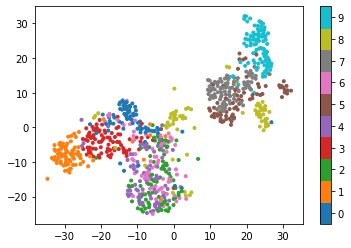

In [452]:
plt.scatter(*ump.y_centers.cpu().data.numpy().T, c=yy, marker='.', cmap="tab10")
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))

## UMAP - from library

In [69]:
import umap

In [454]:
embed = umap.UMAP(n_neighbors=100, n_components=2, min_dist=0.1, spread=1, metric="euclidean", negative_sample_rate=5)
# embed = umap.UMAP(n_neighbors=784, n_components=2, min_dist=0.1, spread=1,
# #                   target_metric='euclidean',
#                   target_metric='categorical',
#                   target_weight=0.1
#                  )

In [455]:
embedding = embed.fit_transform(xx.data.cpu().numpy())
# embedding = embed.fit_transform(centers, output_cent)

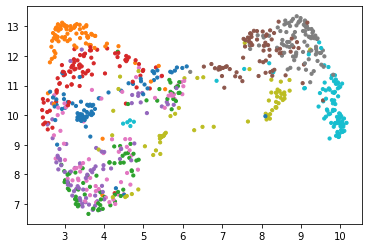

In [456]:
plt.scatter(embedding[:,0], embedding[:, 1], c=yy, s=10, cmap="tab10")

In [446]:
j = 0

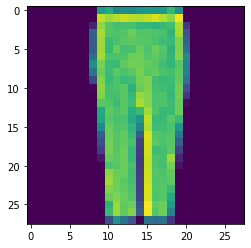

In [448]:
plt.imshow(xx.cpu()[j].reshape(28,28))
j += 1

### Visualization of centroid Activation

In [847]:
def get_sigma(dists, num_knn=100, epoch=300):
    sigma = nn.Parameter(torch.std(dists.data, dim=1, keepdim=True)*0.2)
    optim = torch.optim.Adam([sigma], lr=0.03)
#     num_knn = dists.shape[1]
    
    target = torch.log2(torch.ones_like(sigma)*num_knn).to(dists.device)
    dists, _ = torch.topk(dists, num_knn, dim=1, largest=False, sorted=False)
    
    for i in range(epoch):
        delta = torch.sum(torch.exp(-dists/sigma), dim=1, keepdim=True)
        delta = delta-target

        optim.zero_grad()
        error = (delta**2).sum()
        error.backward()
        optim.step()

    return sigma.data

In [848]:
NC = 5000
dt = DistanceTransform(784, NC).to(device)
# dt.set_centroid_to_data_randomly(train_loader)
indices = np.random.permutation(len(train_loader.dataset.data))[:NC]
xx, yy_ = train_loader.dataset[indices]
dt.centers.data = xx.data.to(device)

indices = np.random.permutation(len(test_loader.dataset.data))[:50]
xx, yy = test_loader.dataset[indices]

dists = dt(xx.to(device))

In [849]:
NK = 100

In [850]:
ds = dists.shape
dists, indices = torch.topk(dists, k=NK, dim=1, largest=False, sorted=False)
# classes = torch.gather(yy_.expand(indices.shape[0], -1), index=indices.cpu(), dim=1)

dists = (dists-dists.min(dim=1, keepdim=True)[0])
# sigma = torch.sqrt(dists.var(dim=1, keepdim=True)+1e-5)
sigma = get_sigma(dists.data, epoch=500, num_knn=100)

dists = dists/sigma
dists = torch.exp(-dists)

dists = torch.zeros(*ds).to(device).scatter_(dim=1, index=indices, src=dists)

In [851]:
# dists.gather(dim=1, index=indices).shape

In [852]:
sigma

tensor([[0.4550],
        [0.3392],
        [0.3310],
        [0.7390],
        [0.6352],
        [0.5861],
        [0.6835],
        [0.7100],
        [0.7723],
        [0.4834],
        [0.7687],
        [0.4596],
        [0.4150],
        [0.4393],
        [0.4585],
        [0.2256],
        [0.4481],
        [0.5340],
        [0.4629],
        [0.4403],
        [0.3761],
        [0.6218],
        [0.5483],
        [0.4228],
        [0.6279],
        [0.2263],
        [0.5224],
        [0.4966],
        [0.4851],
        [0.3284],
        [0.1494],
        [0.6808],
        [0.3939],
        [0.4010],
        [0.5522],
        [0.3677],
        [1.1107],
        [0.4599],
        [0.5467],
        [0.3269],
        [0.4304],
        [0.4843],
        [0.5971],
        [0.8254],
        [0.5796],
        [0.7262],
        [0.4636],
        [0.4347],
        [0.5377],
        [0.7094]], device='cuda:0')

In [853]:
dists.shape

torch.Size([50, 5000])

In [854]:
embed = umap.UMAP(n_neighbors=NK, n_components=2, min_dist=0.1, spread=1, metric="euclidean", negative_sample_rate=5)
embedding = embed.fit_transform(dt.centers.data.cpu().numpy())

In [855]:
cent_classes = yy_.data.cpu().numpy()

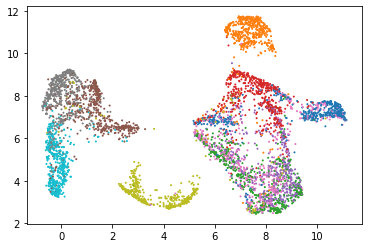

In [856]:
plt.scatter(embedding[:,0], embedding[:, 1], c=cent_classes, s=1, cmap="tab10")

In [914]:
i=0

100 6.643856
Class: 3, Maxsize class: 3
15/50


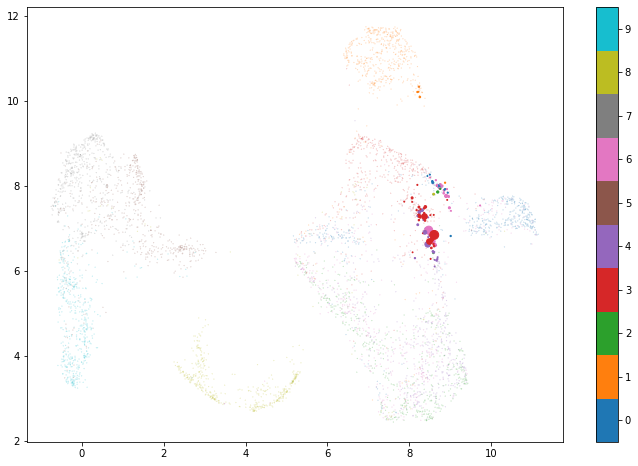

In [929]:
activ = dists.data.cpu().numpy()[i]

plt.figure(figsize=(12,8))
#plt.scatter(embedding[:,0], embedding[:, 1], color="b", s=np.maximum(activ*80, 0.1), cmap="tab10")

# actmask = activ>0.001
# activ = activ*[actmask]
print(np.count_nonzero(actmask), activ.sum())
print(f"Class: {yy[i]}, Maxsize class: {cent_classes[activ.argmax()]}")
# plt.scatter(embedding[:,0], embedding[:, 1], c=cent_classes, s=activ*80, cmap="tab10")
plt.scatter(embedding[:,0], embedding[:, 1], c=cent_classes, s=np.maximum(activ*80, 0.01), cmap="tab10")
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))

i += 1
print(f"{i}/{len(dists)}")
plt.show()

100 6.643856 TopK: 0.009509
Class: 2, Maxsize class: 2
44/50


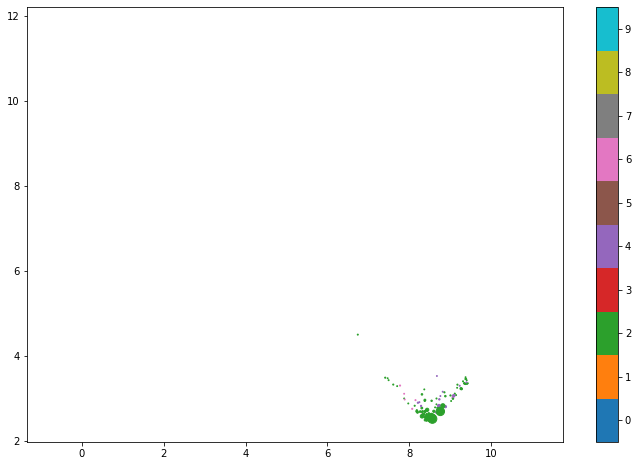

In [904]:
activ = dists.data.cpu().numpy()[i]

plt.figure(figsize=(12,8))
topkval = np.sort(activ)[-NK]
actmask = activ >= topkval
activ = activ*[actmask]
print(np.count_nonzero(actmask), activ.sum(), f"TopK: {topkval:5f}")
print(f"Class: {yy[i]}, Maxsize class: {cent_classes[activ.argmax()]}")
plt.scatter(embedding[:,0], embedding[:, 1], c=cent_classes, s=activ*80, cmap="tab10")
# plt.scatter(embedding[:,0], embedding[:, 1], c=cent_classes, s=np.maximum(activ*100, 0.1), cmap="tab10")
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))

i += 1
print(f"{i}/{len(dists)}")
plt.show()

In [905]:
i=i-1

### Nearest Centroids attract towards given value

In [966]:
model = DistanceTransform(784, 1000, p=2).to(device)

model.set_centroid_to_data_randomly(train_loader)

In [968]:
NK = 100

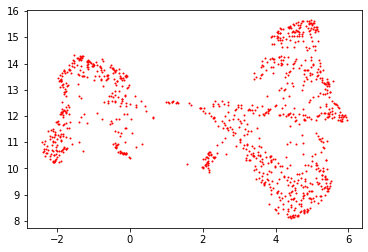

In [969]:
embed = umap.UMAP(n_neighbors=NK, n_components=2, min_dist=0.1, spread=1, metric="euclidean", negative_sample_rate=5)
embedding = embed.fit_transform(model.centers.data.cpu().numpy())

plt.scatter(embedding[:,0], embedding[:, 1], color="r", s=1, cmap="tab10")

In [970]:
xx.shape

torch.Size([50, 784])

In [1031]:
for xx, yy in train_loader:
    xx, yy = xx.to(device), yy.to(device)
    dists = model(xx)

In [1037]:
# ds = dists.shape
dists_, indices = torch.topk(dists, k=NK, dim=1, largest=False, sorted=True)
# dists = torch.zeros(*ds).to(device).scatter_(dim=1, index=indices, src=dists)

In [1041]:
mask = dists <= dists_[:, -1:]

In [1042]:
pos_dist = dists[mask]
neg_dist = dists[~mask]

In [1044]:
pos_dist.shape

torch.Size([5000])

In [985]:
loss = dists.mean()
loss

tensor(5.9790, device='cuda:0', grad_fn=<MeanBackward0>)

In [1570]:
model = DistanceTransform(784, 1000, p=2)
# model.set_centroid_to_data_randomly(train_loader)
model.set_centroid_to_data_maxdist(train_loader)
model.to(device)

100%|██████████| 1200/1200 [00:11<00:00, 103.12it/s]


DistanceTransform()

In [1571]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00003)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.003)

In [1572]:
def dist_loss(distances):
    return (distances**2).mean()
#     return distances.abs().mean()

  0%|          | 0/20 [00:00<?, ?it/s]

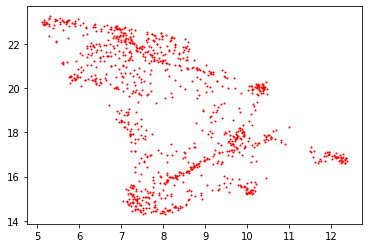

Epoch: 0:0.00725490553304553,  Train Loss:-991.75569


  5%|▌         | 1/20 [00:05<01:50,  5.82s/it]

Test Loss:-992.15275

Epoch: 1:0.00725490553304553,  Train Loss:-1055.90253


 10%|█         | 2/20 [00:08<01:16,  4.23s/it]

Test Loss:-1054.03804

Epoch: 2:0.00725490553304553,  Train Loss:-1125.00570


 15%|█▌        | 3/20 [00:11<01:02,  3.69s/it]

Test Loss:-1117.86630

Epoch: 3:0.00725490553304553,  Train Loss:-1187.09601


 20%|██        | 4/20 [00:15<00:55,  3.48s/it]

Test Loss:-1183.64417

Epoch: 4:0.00725490553304553,  Train Loss:-1252.07904


 25%|██▌       | 5/20 [00:18<00:50,  3.34s/it]

Test Loss:-1251.37226



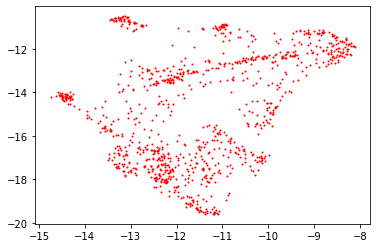

Epoch: 5:0.00725490553304553,  Train Loss:-1322.93918


 30%|███       | 6/20 [00:24<00:58,  4.19s/it]

Test Loss:-1321.04024

Epoch: 6:0.00725490553304553,  Train Loss:-1398.17087


 35%|███▌      | 7/20 [00:27<00:49,  3.83s/it]

Test Loss:-1392.65357

Epoch: 7:0.00725490553304553,  Train Loss:-1471.22451


 40%|████      | 8/20 [00:30<00:43,  3.61s/it]

Test Loss:-1466.22243

Epoch: 8:0.00725490553304553,  Train Loss:-1550.87356


 45%|████▌     | 9/20 [00:33<00:37,  3.45s/it]

Test Loss:-1541.75158

Epoch: 9:0.00725490553304553,  Train Loss:-1624.76515


 50%|█████     | 10/20 [00:36<00:33,  3.33s/it]

Test Loss:-1619.22969



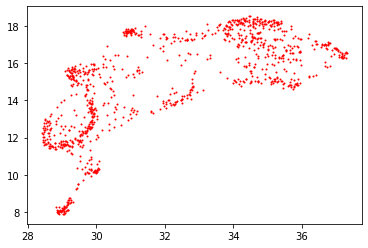

Epoch: 10:0.00725490553304553,  Train Loss:-1701.31693


 55%|█████▌    | 11/20 [00:42<00:36,  4.10s/it]

Test Loss:-1698.65100

Epoch: 11:0.00725490553304553,  Train Loss:-1783.82712


 60%|██████    | 12/20 [00:45<00:30,  3.80s/it]

Test Loss:-1780.02301

Epoch: 12:0.00725490553304553,  Train Loss:-1868.71618


 65%|██████▌   | 13/20 [00:48<00:25,  3.59s/it]

Test Loss:-1863.35138

Epoch: 13:0.00725490553304553,  Train Loss:-1955.01662


 70%|███████   | 14/20 [00:51<00:20,  3.45s/it]

Test Loss:-1948.62238

Epoch: 14:0.00725490553304553,  Train Loss:-2039.46027


 75%|███████▌  | 15/20 [00:54<00:16,  3.34s/it]

Test Loss:-2035.85233



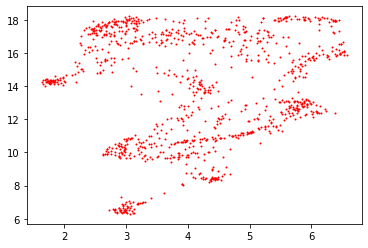

Epoch: 15:0.00725490553304553,  Train Loss:-2138.31368


 80%|████████  | 16/20 [01:01<00:17,  4.27s/it]

Test Loss:-2125.03563

Epoch: 16:0.00725490553304553,  Train Loss:-2219.85037


 85%|████████▌ | 17/20 [01:04<00:11,  3.94s/it]

Test Loss:-2216.17006

Epoch: 17:0.00725490553304553,  Train Loss:-2306.49915


 90%|█████████ | 18/20 [01:07<00:07,  3.70s/it]

Test Loss:-2309.26062

Epoch: 18:0.00725490553304553,  Train Loss:-2422.89238


 95%|█████████▌| 19/20 [01:10<00:03,  3.54s/it]

Test Loss:-2404.30662

Epoch: 19:0.00725490553304553,  Train Loss:-2503.49520


100%|██████████| 20/20 [01:13<00:00,  3.69s/it]

Test Loss:-2501.29881



In [1693]:
loss_tr = EMA()
loss_te = EMA()
for epoch in tqdm(list(range(20))):
    for xx, yy in train_loader:
#         if epoch == 0: break
        xx, yy = xx.to(device), yy.to(device)
        dists = model(xx)
        
#         dists, indices = torch.topk(dists, k=NK, dim=1, largest=False, sorted=False)
#         loss = dist_loss(dists)
        
        dists_, indices = torch.topk(dists, k=NK, dim=1, largest=False, sorted=True)
        mask = dists <= dists_[:, -1:]
        pos_dist = dists[mask]
        neg_dist = dists[~mask]
        loss = dist_loss(pos_dist)-dist_loss(neg_dist)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_tr(float(loss))
    
    if epoch%5 == 0:
        embed = umap.UMAP(n_neighbors=NK, n_components=2, min_dist=0.1, spread=1, metric="euclidean", negative_sample_rate=5)
        embedding = embed.fit_transform(model.centers.data.cpu().numpy())
        plt.scatter(embedding[:,0], embedding[:, 1], color="r", s=1, cmap="tab10")
        plt.show()

    print(f'Epoch: {epoch}:{index},  Train Loss:{loss_tr.mu:.5f}')
    loss_ma = EMA()
    for xx, yy in test_loader:
        xx, yy = xx.to(device), yy.to(device)
        with torch.no_grad():
            yout = model(xx)
            dists = model(xx)
#             dists, indices = torch.topk(dists, k=NK, dim=1, largest=False, sorted=False)
#             loss = dist_loss(dists)
            
            dists_, indices = torch.topk(dists, k=NK, dim=1, largest=False, sorted=True)
            mask = dists <= dists_[:, -1:]
            pos_dist = dists[mask]
            neg_dist = dists[~mask]
            loss = dist_loss(pos_dist)-dist_loss(neg_dist)

            loss_te(float(loss))
            
    print(f'Test Loss:{loss_te.mu:.5f}')
    print()

In [1694]:
embed = umap.UMAP(n_neighbors=700, n_components=2, min_dist=0.1, spread=1, metric="euclidean", negative_sample_rate=5)
embedding = embed.fit_transform(model.centers.data.cpu().numpy())

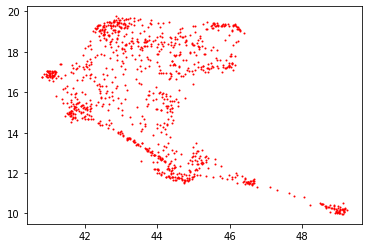

In [1695]:
plt.scatter(embedding[:,0], embedding[:, 1], color="r", s=1, cmap="tab10")

In [1696]:
## test on random examples

indices = np.random.permutation(len(test_loader.dataset.data))[:50]
xx, yy = test_loader.dataset[indices]

In [1697]:
def get_sigma(dists, num_knn=100, epoch=300):
    sigma = nn.Parameter(torch.std(dists.data, dim=1, keepdim=True)*0.2)
    optim = torch.optim.Adam([sigma], lr=0.01)
#     num_knn = dists.shape[1]
    
    target = torch.log2(torch.ones_like(sigma)*num_knn).to(dists.device)
    dists, _ = torch.topk(dists, num_knn, dim=1, largest=False, sorted=False)
    
    for i in range(epoch):
        delta = torch.sum(torch.exp(-dists/sigma), dim=1, keepdim=True)
        delta = delta-target
        
        optim.zero_grad()
        error = (delta**2).sum()
        error.backward()
        
        sigma.grad[torch.isnan(sigma.grad)] = 0
        sigma.grad[torch.isinf(sigma.grad)] = 0
        
        
        optim.step()
        sigma.data.abs_()

    return sigma.data

In [1698]:
dists = model(xx.to(device))

ds = dists.shape
dists, indices = torch.topk(dists, k=NK, dim=1, largest=False, sorted=True)
print(dists)

dists = (dists-dists.min(dim=1, keepdim=True)[0])
sigma = get_sigma(dists.data, epoch=500, num_knn=100)

print(sigma)

dists = dists/sigma
dists = torch.exp(-dists)
dists = torch.zeros(*ds).to(device).scatter_(dim=1, index=indices, src=dists)

tensor([[8.9776, 9.0126, 9.0611,  ..., 9.7042, 9.7178, 9.8463],
        [5.6676, 5.6977, 5.7002,  ..., 7.8841, 7.8841, 9.0101],
        [5.1092, 5.1135, 5.1223,  ..., 8.2643, 8.2643, 8.2643],
        ...,
        [6.1536, 6.3598, 6.4179,  ..., 8.9749, 8.9824, 9.1594],
        [6.3297, 6.3351, 6.3432,  ..., 8.1058, 8.1911, 8.3089],
        [7.1565, 7.3886, 7.4184,  ..., 9.3841, 9.6206, 9.7821]],
       device='cuda:0', grad_fn=<TopkBackward>)
tensor([[1.0012e-01],
        [3.5062e-24],
        [4.5159e-02],
        [3.4561e-01],
        [1.0282e-01],
        [5.0495e-01],
        [7.9146e-27],
        [2.3977e-01],
        [1.2811e-01],
        [1.3308e-24],
        [7.0396e-02],
        [1.2485e-26],
        [8.5560e-01],
        [1.6925e-24],
        [2.3628e-26],
        [5.4336e-02],
        [1.0622e-24],
        [3.8197e-01],
        [6.0602e-01],
        [8.7634e-03],
        [1.5782e-01],
        [6.4475e-01],
        [5.9846e-01],
        [1.4510e-04],
        [3.0952e-01],
    

In [1699]:
i=0

100 6.643856
Class: 2
50/50


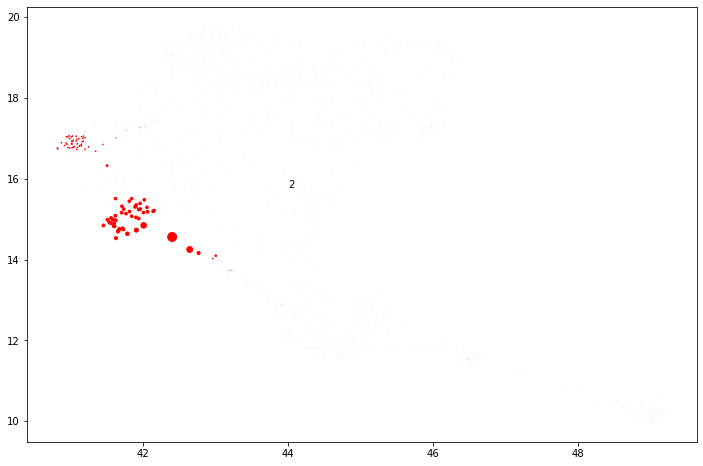

In [1752]:
activ = dists.data.cpu().numpy()[i]

plt.figure(figsize=(12,8))
#plt.scatter(embedding[:,0], embedding[:, 1], color="b", s=np.maximum(activ*80, 0.1), cmap="tab10")

# actmask = activ>0.001
# activ = activ*[actmask]
print(np.count_nonzero(actmask), activ.sum())
print(f"Class: {yy[i]}")
plt.scatter(embedding[:,0], embedding[:, 1], color="r", s=np.maximum(activ*80, 0.001), cmap="tab10")
plt.text(embedding[:,0].mean(), embedding[:,1].mean(), f"{yy[i]}")

i += 1
print(f"{i}/{len(dists)}")
plt.show()

In [1751]:
i-=1

In [1660]:
j = 0

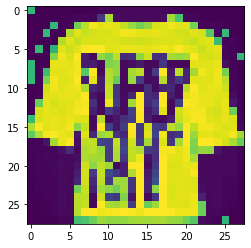

In [1692]:
plt.imshow(model.centers.data.cpu()[j].reshape(28,28))
j += 1

### Using my pytorchUMAPper